# Project 4: Trees and gradient boosting
Gavri Kepets and Ayden Shankman

In [ ]:
!pip show xgboost==1.3.3
!pip install xgboost==1.3.3
from sklearn.datasets import fetch_california_housing
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def regression(features, labels, test_size): # runs regression with xgboost given features, labels, and a test split
  x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size) # split data
  regression = xgb.XGBRegressor(objective ='reg:pseudohubererror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 3, alpha = 5, n_estimators = 800, eval_metric=mean_absolute_error) # same hyperparameters as used in the book
  regression.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test, y_test)], verbose=False) # run regression

  results = regression.evals_result()

  plt.figure()
  plt.plot(results['validation_0']['mphe'], label='train')
  plt.plot(results['validation_1']['mphe'], label='test')
  plt.title("Training and Test Absolute Error")
  plt.xlabel("Iterations M")
  plt.ylabel("Absolute Error")
  plt.legend()

  return regression, x_train

In [ ]:
def importance(regression, columns): # gets the importance graph given labels (columns) and the regression model
  importance = tuple(zip(columns, regression.feature_importances_)) # get importances and sort them into tuples of (label, value)
  sorted_i = sorted(importance, key=lambda tup: tup[1])
  sorted_i.reverse()
  labels = [tup[0] for tup in sorted_i]
  widths = [tup[1] for tup in sorted_i]

  widths = widths / max(widths) * 100 # normalize to 100 scale

  plt.figure()
  plt.yticks(range(len(sorted_i)), labels=labels)
  plt.barh(range(len(sorted_i)), widths)
  plt.title("Relative Importance of the Predictors")
  plt.xlabel("Relative Importance")

In [ ]:
def partial_dependencies(regression, x_train, features): # gives four partial dependency graphs based on input features
  fig, ax = plt.subplots(2,2, figsize=(8,8))
  PartialDependenceDisplay.from_estimator(regression, x_train, features, ax=ax)

In [ ]:
def partial_dependencies_mesh(regression, x_train, features, title): # generates a 3D mesh for partial dependencies between two features
  fig = plt.figure()
  pd, axes = partial_dependence(r, x_train, features=features, grid_resolution=15)
  fig = plt.figure()
  XX, YY = np.meshgrid(axes[0], axes[1]) # create x and y values
  Z = pd[0].T
  
  # plot surface
  ax = Axes3D(fig)
  surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])
  ax.set_zlabel('Partial dependence')
  fig.suptitle(title)

# California Housing Dataset

/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_partial_dependence.py:513: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,


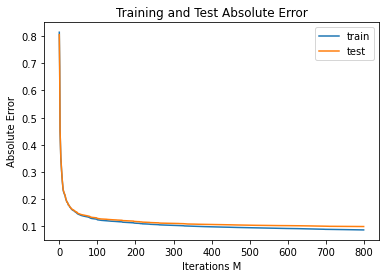

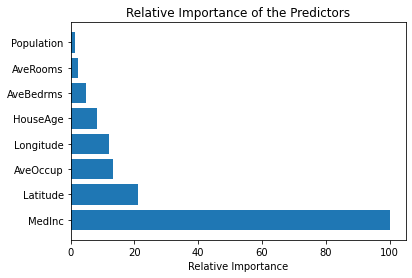

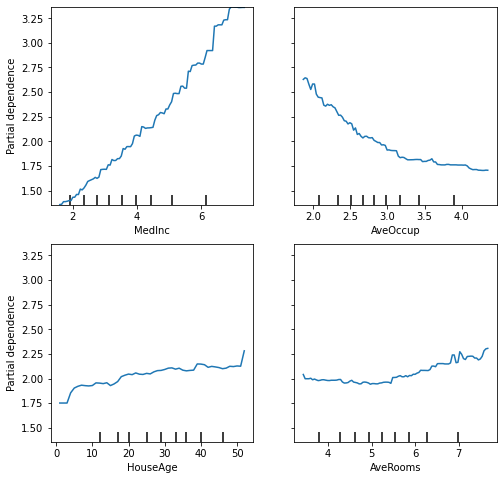

<Figure size 432x288 with 0 Axes>

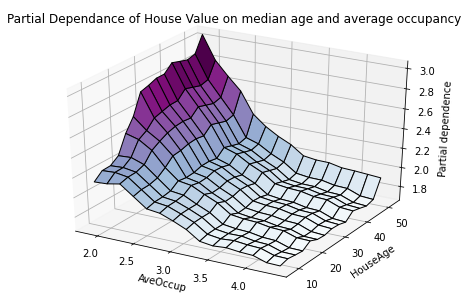

In [ ]:
california_housing = fetch_california_housing(as_frame=True)
california_housing_data = california_housing.data
california_housing_labels = california_housing.target

r, x_train = regression(california_housing_data, california_housing_labels, 0.2)
i = importance(r, ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
partial_dependencies(r, x_train, ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms'])
partial_dependencies_mesh(r, x_train, ['AveOccup', 'HouseAge'], 'Partial Dependance of House Value on median age and average occupancy')

For the California housing dataset, house value was highly dependant on median income, and slightly dependent on location and occupancy. There was a strong interation between occupancy and house age, where the partial dependency of value on these two features went up when occupancy was low and age was high.

# Song Popularity Dataset
https://www.kaggle.com/datasets/yasserh/song-popularity-dataset

In [ ]:
songs = pd.read_csv("song_data.csv")
songs.drop(["song_name"], axis=1, inplace=True)
songs_data = songs.iloc[:, 1:]
songs_labels = songs.iloc[:, 0]

r, x_train = regression(songs_data, songs_labels, 0.2)
i = importance(r, ['song_duration_ms','acousticness','danceability','energy','instrumentalness','key','liveness','loudness','audio_mode','speechiness','tempo','time_signature','audio_valence'])
partial_dependencies(r, x_train, ['song_duration_ms','acousticness','key','instrumentalness'])
partial_dependencies_mesh(r, x_train, ['acousticness', 'song_duration_ms'], 'Partial Dependance of popularity on acousticness and song duration')
partial_dependencies_mesh(r, x_train, ['energy', 'danceability'], 'Partial Dependance of popularity on energy and danceability')

/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_partial_dependence.py:513: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,


For the song popularity dataset, fifteen features are used to determine a popularity score between 0 and 100. According to the relative importance of the predictors, acousticness, song duration, instrumentalness, and tempo are the most important features for a song. First, we tested the correlation between song duration and accousticness. These appeared to not be correlated, as no matter what happens, a low accousticness resulted in a higher partial dependence, and there is also a sweet spot for how long a song should be (about 230 seconds, just about under four minutes). There is an exception when accousticness is low, and song duration is high, where they cause a higher partial independence. We also looked at the interactions between energy and danceability. The outcome was interesting; it appears that songs partial dependence of popularity on energy and danceability goes up when energy is low and danceability is high (slow dance songs?).